# Topic Modeling of Newsgroup Data Using LDA (Latent Dirichlet Allocation)

## Importing the Required Libraries

In [19]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#vis
#! pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from tqdm import tqdm 
tqdm.pandas()
import re
from pprint import pprint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Lets Import NewsGroupData

In [12]:
newsata = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(newsata.target_names.unique())
newsata.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [13]:
newsata['content'][0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [14]:
newsata['content'][1]

"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.\n\nGuy Kuo <guykuo@u.washington.edu>\n"

## Preprocess the content data

### Lets Prepare stop words

In [15]:
# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Lets Remove emails and newline charecters

In [22]:
# Convert to list
newsdata_preprocessed = newsata.content.values.tolist()

# Remove Emails
newsdata_preprocessed = [re.sub('\S*@\S*\s?', '', sent) for sent in tqdm(newsdata_preprocessed)]

# Remove new line characters
newsdata_preprocessed = [re.sub('\s+', ' ', sent) for sent in tqdm(newsdata_preprocessed)]

# Remove distracting single quotes
newsdata_preprocessed = [re.sub("\'", "", sent) for sent in tqdm(newsdata_preprocessed)]
print()
pprint(newsdata_preprocessed[:1])

100%|██████████| 11314/11314 [00:00<00:00, 164418.68it/s]


['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


### Lets Tokenise and clean up text

In [24]:
def sent_to_words(sentences):
    for sentence in tqdm(sentences):
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

newsdata_preprocessed_words = list(sent_to_words(newsdata_preprocessed))
print(newsdata_preprocessed_words[:1])

100%|██████████| 11314/11314 [00:08<00:00, 1341.57it/s]

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


### Lets create bi-grams and tri-grams

In [26]:
# Build the bigram and trigram models
newsdata_preprocessed_words_bigram = gensim.models.Phrases(newsdata_preprocessed_words, min_count=5, threshold=100) # higher threshold fewer phrases.
newsdata_preprocessed_words_trigram = gensim.models.Phrases(newsdata_preprocessed_words_bigram[newsdata_preprocessed_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_model = gensim.models.phrases.Phraser(newsdata_preprocessed_words_bigram)
trigram_model = gensim.models.phrases.Phraser(newsdata_preprocessed_words_trigram)

# See trigram example
print(trigram_model[bigram_model[newsdata_preprocessed_words[0]]])

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


### lets Remove Stopwords, Make Bigrams and Lemmatize

In [30]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tqdm(texts)]

def make_bigrams(texts):
    return [bigram_model[doc] for doc in tqdm(texts)]

def make_trigrams(texts):
    return [trigram_model[bigram_model[doc]] for doc in tqdm(texts)]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tqdm(texts):
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [35]:
# Remove Stop Words
newsdata_preprocessed_words_nostops = remove_stopwords(newsdata_preprocessed_words)

# Form Bigrams
newsdata_preprocessed_words_bigrams = make_bigrams(newsdata_preprocessed_words_nostops)

# Initialize spacy 'en' mo!del, keeping only tagger component (for efficiency)
#!python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
newsdata_preprocessed_lemmatized = lemmatization(newsdata_preprocessed_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(newsdata_preprocessed_lemmatized[:1])

100%|██████████| 11314/11314 [02:39<00:00, 70.78it/s]

[['s', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


### Lets create a dictionary for topic modeling

In [43]:
# Create Dictionary
id2word = corpora.Dictionary(newsdata_preprocessed_lemmatized)

# Term Document Frequency
newsdata_corpus = [id2word.doc2bow(text) for text in tqdm(newsdata_preprocessed_lemmatized)]

# View
print(newsdata_corpus[:1])

100%|██████████| 11314/11314 [00:01<00:00, 6404.46it/s]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


#### Lets see a document in the corpus

In [44]:
[[(id2word[id], freq) for id, freq in cp] for cp in newsdata_corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('wonder', 1),
  ('year', 1)]]

### Lets Build LDA Model

In [47]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=newsdata_corpus,id2word=id2word,num_topics=20,random_state=100,update_every=1,chunksize=100,passes=10,alpha='auto', per_word_topics=True)
lda_model.print_topics()

[(0,
  '0.018*"player" + 0.017*"lose" + 0.013*"good" + 0.012*"season" + 0.012*"tape" + 0.010*"goal" + 0.010*"next" + 0.010*"trade" + 0.008*"well" + 0.008*"go"'),
 (1,
  '0.012*"point" + 0.012*"case" + 0.010*"use" + 0.010*"also" + 0.010*"group" + 0.009*"many" + 0.009*"issue" + 0.009*"make" + 0.009*"book" + 0.008*"question"'),
 (2,
  '0.027*"people" + 0.025*"say" + 0.018*"believe" + 0.016*"evidence" + 0.015*"think" + 0.013*"reason" + 0.011*"claim" + 0.010*"sense" + 0.009*"know" + 0.009*"make"'),
 (3,
  '0.020*"bike" + 0.014*"engine" + 0.013*"ride" + 0.009*"mile" + 0.009*"vehicle" + 0.008*"moon" + 0.008*"large" + 0.007*"rider" + 0.007*"dog" + 0.007*"cycle"'),
 (4,
  '0.022*"drive" + 0.018*"use" + 0.017*"window" + 0.016*"system" + 0.015*"card" + 0.014*"run" + 0.012*"problem" + 0.011*"do" + 0.011*"driver" + 0.010*"software"'),
 (5,
  '0.038*"space" + 0.026*"test" + 0.017*"server" + 0.015*"faq" + 0.014*"item" + 0.011*"material" + 0.011*"launch" + 0.010*"mission" + 0.010*"research" + 0.010*"p

In [49]:
doc_lda = lda_model[newsdata_corpus]

### Lets Compute Model Perplexity and Coherence Score

In [50]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(newsdata_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=newsdata_preprocessed_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.306319512430779

Coherence Score:  0.5003920264702689


### Lets Visualize the topics-keywords

In [52]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, newsdata_corpus, id2word)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.315131  0.019559       1        1  20.201416
1      0.231767 -0.098335       2        1  12.540211
2      0.273995  0.134205       3        1  10.368423
17     0.222269  0.101755       4        1   8.508726
4      0.093699 -0.286714       5        1   7.774963
7     -0.132679  0.038933       6        1   5.617644
9      0.027332 -0.257146       7        1   4.997182
0      0.081196  0.080153       8        1   3.604905
6     -0.038011  0.156333       9        1   2.943667
18    -0.026511  0.017014      10        1   2.636517
19    -0.061436  0.118401      11        1   2.516457
5     -0.101149 -0.107065      12        1   2.433709
16    -0.071566  0.117021      13        1   2.429020
3     -0.107132 -0.049537      14        1   2.328035
10    -0.100994 -0.102644      15        1   2.200762
12    -0.099158 -0.026890      16        1   2.176981
11    -0.081850  0.048460      17        1   2.128726
13    -0.131735  0.065494      18        1   1.762159
15    -0.141940 -0.005906      19        1   1.443415
14    -0.151227  0.036908      20        1   1.387082, topic_info=              Term          Freq         Total Category  logprob  loglift
4329            ax  40896.000000  40896.000000  Default  30.0000  30.0000
17            line  12290.000000  12290.000000  Default  29.0000  29.0000
206          write   9885.000000   9885.000000  Default  28.0000  28.0000
44         article   7092.000000   7092.000000  Default  27.0000  27.0000
143   organization   6609.000000   6609.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
1301          fire    217.442611    513.930882  Topic20  -4.3987   3.4178
4528            pm    100.338088    149.646633  Topic20  -5.1721   3.8782
780           tank     88.171484    140.213884  Topic20  -5.3013   3.8141
130              m    117.093915   4073.030590  Topic20  -5.0176   0.7288
970          cover     76.434460    632.588097  Topic20  -5.4442   2.1646

[998 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4326      6  0.999006         _
1342      9  0.208299    accept
1342     18  0.680977    accept
1342     19  0.109490    accept
937      13  0.992216  accident
...     ...       ...       ...
39        1  0.159664      year
39        2  0.089601      year
39        4  0.457777      year
39       10  0.292531      year
5304     17  0.991149     youth

[1602 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 3, 18, 5, 8, 10, 1, 7, 19, 20, 6, 17, 4, 11, 13, 12, 14, 16, 15])

### Lets Build LDA Mallet Model

In [61]:
!gdown http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

Downloading...
From: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
To: /content/mallet-2.0.8.zip
100% 16.2M/16.2M [00:00<00:00, 17.3MB/s]
Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [66]:
mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=newsdata_corpus, num_topics=20, id2word=id2word)
pprint(ldamallet.show_topics(formatted=False))


[(11,
  [('study', 0.008577659316694936),
   ('doctor', 0.007899200387690817),
   ('effect', 0.007778047007511509),
   ('article', 0.00743881754300945),
   ('disease', 0.007317664162830143),
   ('patient', 0.007148049430579113),
   ('medical', 0.006687666585897746),
   ('problem', 0.006469590501574994),
   ('_', 0.006178822389144657),
   ('health', 0.00605766900896535)]),
 (0,
  [('write', 0.027572220664063344),
   ('ve', 0.02135876248624625),
   ('thing', 0.01989169597203944),
   ('make', 0.018726672563698733),
   ('time', 0.01676339237556903),
   ('day', 0.016482923777264784),
   ('hear', 0.015878837565532565),
   ('start', 0.01404500442277405),
   ('bad', 0.013376194688356238),
   ('lot', 0.012275894802701129)]),
 (14,
  [('drive', 0.028831087433406455),
   ('card', 0.02392759046583221),
   ('problem', 0.022950577912142608),
   ('system', 0.01898722510000553),
   ('bit', 0.015300385274761737),
   ('driver', 0.014231201725441038),
   ('scsi', 0.012996110383984369),
   ('work', 0.0126

In [67]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=newsdata_preprocessed_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.6045697330914265


### Lets Visualize the topics-keywords

In [75]:
def convertldaGenToldaMallet(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

ldamallet = convertldaGenToldaMallet(ldamallet)

In [77]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamallet, newsdata_corpus, id2word)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.165269  0.225057       1        1  6.505474
17     0.172319 -0.230007       2        1  6.112436
5     -0.151602 -0.005225       3        1  5.904460
19    -0.217257 -0.051626       4        1  5.808059
2     -0.180502 -0.021971       5        1  5.563399
4     -0.045512  0.122993       6        1  5.508888
12     0.036404  0.152628       7        1  5.286372
3     -0.142925  0.000213       8        1  5.263533
6     -0.157428 -0.004091       9        1  5.139586
13    -0.013750 -0.047533      10        1  5.063035
8     -0.045973  0.101919      11        1  4.947127
1      0.061635  0.151172      12        1  4.823396
9     -0.209912 -0.062444      13        1  4.803076
14     0.233957  0.163006      14        1  4.647810
0     -0.106621 -0.114270      15        1  4.385156
18     0.049723  0.015523      16        1  4.355272
7      0.108407  0.091335      17        1  4.272582
11     0.025957 -0.019806      18        1  4.137238
15     0.233889 -0.142309      19        1  3.892985
16     0.183921 -0.324564      20        1  3.580117, topic_info=            Term          Freq         Total Category  logprob  loglift
4329          ax  74486.000000  74486.000000  Default  30.0000  30.0000
17          line  13792.000000  13792.000000  Default  29.0000  29.0000
206        write  11343.000000  11343.000000  Default  28.0000  28.0000
44       article   8210.000000   8210.000000  Default  27.0000  27.0000
24    nntp_poste   5218.000000   5218.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
579     previous    113.095452    476.156214  Topic20  -6.0006   1.8923
915         mine     91.346327    308.630642  Topic20  -6.2142   2.1123
119         hear    142.456772   1820.358378  Topic20  -5.7698   0.7820
602      thought     95.696156    394.896391  Topic20  -6.1676   1.9123
472        wrong    112.008000   1238.989347  Topic20  -6.0102   0.9263

[1854 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
4326      1  0.002942               _
4326      2  0.038248               _
4326     18  0.959155               _
494       3  0.999839        absolute
2611      3  0.998012  absolute_truth
...     ...       ...             ...
612       3  0.835071            yhwh
1824     20  1.003175       youve_got
1110     18  1.005775              yr
9358     13  0.994408         zionism
9359     13  0.994408         zionist

[3610 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 18, 6, 20, 3, 5, 13, 4, 7, 14, 9, 2, 10, 15, 1, 19, 8, 12, 16, 17])

### Finding optimal number of topics for LDA

In [79]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

100%|██████████| 7/7 [22:30<00:00, 192.90s/it]


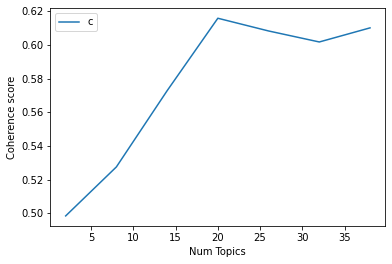

In [80]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=newsdata_corpus, texts=newsdata_preprocessed_lemmatized, start=2, limit=40, step=6)
# show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [81]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4985
Num Topics = 8  has Coherence Value of 0.5276
Num Topics = 14  has Coherence Value of 0.5728
Num Topics = 20  has Coherence Value of 0.6158
Num Topics = 26  has Coherence Value of 0.6082
Num Topics = 32  has Coherence Value of 0.6017
Num Topics = 38  has Coherence Value of 0.6101


* We have high coherence at 20 topics hence we will create a model with 20 topics.

In [82]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(0,
  '0.010*"study" + 0.009*"problem" + 0.008*"food" + 0.008*"science" + '
  '0.007*"effect" + 0.007*"doctor" + 0.006*"disease" + 0.006*"case" + '
  '0.006*"patient" + 0.006*"eat"'),
 (1,
  '0.030*"post" + 0.026*"mail" + 0.020*"group" + 0.020*"send" + 0.020*"book" + '
  '0.017*"list" + 0.017*"information" + 0.016*"address" + 0.015*"internet" + '
  '0.013*"email"'),
 (2,
  '0.036*"key" + 0.014*"system" + 0.014*"encryption" + 0.012*"government" + '
  '0.011*"chip" + 0.011*"security" + 0.011*"technology" + 0.010*"bit" + '
  '0.010*"public" + 0.008*"phone"'),
 (3,
  '0.032*"game" + 0.025*"team" + 0.023*"year" + 0.021*"play" + 0.016*"player" '
  '+ 0.014*"win" + 0.011*"good" + 0.011*"season" + 0.009*"hit" + '
  '0.008*"point"'),
 (4,
  '0.016*"people" + 0.012*"armenian" + 0.009*"israeli" + 0.009*"war" + '
  '0.008*"attack" + 0.007*"government" + 0.007*"turkish" + 0.007*"kill" + '
  '0.007*"world" + 0.007*"state"'),
 (5,
  '0.012*"people" + 0.010*"question" + 0.010*"word" + 0.009*"christia

### Lets find the dominant topic in each sentence

In [111]:
def format_topics_sentences(ldamodel=lda_model, corpus=newsdata_corpus, texts=newsdata_preprocessed):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in tqdm(enumerate(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=newsdata_corpus, texts=newsdata_preprocessed)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

11314it [00:38, 292.18it/s]


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,16.0,0.1692,"car, bike, buy, ride, turn, drive, engine, spe...",From: (wheres my thing) Subject: WHAT car is t...
1,1,7.0,0.2066,"drive, card, problem, system, driver, bit, scs...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,7.0,0.1617,"drive, card, problem, system, driver, bit, scs...",From: (Thomas E Willis) Subject: PB questions....
3,3,17.0,0.0995,"line, nntp_poste, write, organization, host, a...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,19.0,0.1598,"window, run, problem, set, application, server...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,9.0,0.3866,"gun, law, people, state, case, crime, weapon, ...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,0.0,0.1044,"study, problem, food, science, effect, doctor,...",From: (brian manning delaney) Subject: Brain T...
7,7,7.0,0.5103,"drive, card, problem, system, driver, bit, scs...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,19.0,0.1033,"window, run, problem, set, application, server...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,7.0,0.2532,"drive, card, problem, system, driver, bit, scs...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


### Lets Find the most representative document for each topic


In [112]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in tqdm(sent_topics_outdf_grpd):
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
# Show
sent_topics_sorteddf_mallet.head()

100%|██████████| 20/20 [00:00<00:00, 660.85it/s]


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7329,"study, problem, food, science, effect, doctor,...","From: Subject: Candida(yeast) Bloom, Fact or F..."
1,1.0,0.5259,"post, mail, group, send, book, list, informati...",From: mathew Subject: Alt.Atheism FAQ: Overvie...
2,2.0,0.9008,"key, system, encryption, government, chip, sec...",From: (Clipper Chip Announcement) Subject: tex...
3,3.0,0.7931,"game, team, year, play, player, win, good, sea...",From: (Rocket) Subject: NHL Final point standi...
4,4.0,0.7554,"people, armenian, israeli, war, attack, govern...",From: Center for Policy Research Subject: Fina...


# Let see the Topic distribution across documents

In [122]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
topic_num_keywords = topic_num_keywords.set_index(['Dominant_Topic'])
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
# Change Column names
df_dominant_topics.columns = ['Topic_Keywords', 'Num_Documents', 'Perc_Documents']
# Show
df_dominant_topics['Dominant_Topic'] = df_dominant_topics.index
df_dominant_topics = df_dominant_topics.reset_index(drop=True)
df_dominant_topics

,Topic_Keywords,Num_Documents,Perc_Documents,Dominant_Topic
0,"study, problem, food, science, effect, doctor,...",518,0.0458,0.0
1,"post, mail, group, send, book, list, informati...",407,0.0360,1.0
2,"key, system, encryption, government, chip, sec...",531,0.0469,2.0
3,"game, team, year, play, player, win, good, sea...",1058,0.0935,3.0
4,"people, armenian, israeli, war, attack, govern...",504,0.0445,4.0
5,"people, question, word, christian, exist, true...",952,0.0841,5.0
6,"write, good, article, thing, make, ve, bad, he...",244,0.0216,6.0
7,"drive, card, problem, system, driver, bit, scs...",1198,0.1059,7.0
8,"line, organization, write, article, man, unive...",271,0.0240,8.0
9,"gun, law, people, state, case, crime, weapon, ...",565,0.0499,9.0
